In [15]:
library(car)
library(lmtest)
library(multcomp)
library(reshape)
library(MASS)
library(pwr)
library(plyr)

v_experimentsData = readr::read_csv('C:/SSD_Gustavo/Repositories/GoTravel/Python/Data/Experiments/OptimizationExperiments.csv')


Attaching package: 'plyr'

The following objects are masked from 'package:reshape':

    rename, round_any

Parsed with column specification:
cols(
  .default = col_integer(),
  ChooseBestComponentProb = col_double(),
  CurrentSolutionInfluence = col_character(),
  DepositRate = col_double(),
  Distributed = col_character(),
  EvaporationRate = col_double(),
  `HV area` = col_double(),
  `HV at 60` = col_double(),
  HeuristicModifier = col_character(),
  ImprovedGetComponents = col_character(),
  LimitPheromones = col_character(),
  LocalSearchFinal = col_character(),
  LocalSearchSteps = col_character(),
  MinPheromoneLimitPercentage = col_character(),
  Name = col_character(),
  NeighbourhoodSize = col_double(),
  NumberGroups = col_double(),
  PheromoneModifier = col_character(),
  StartupTime = col_double(),
  instanceFile = col_character(),
  name = col_character()
  # ... with 2 more columns
)
See spec(...) for full column specifications.


In [3]:
## DATA EXPLORATION
names(v_experimentsData)



[1] "ChooseBestComponentProb"      "CurrentSolutionInfluence"    
 [3] "DepositRate"                  "Distributed"                 
 [5] "EvaporationRate"              "HV area"                     
 [7] "HV at 60"                     "HeuristicModifier"           
 [9] "ImprovedGetComponents"        "Iterations"                  
[11] "LimitPheromones"              "LocalSearchFinal"            
[13] "LocalSearchSteps"             "MaxStagnantGenerations"      
[15] "MinPheromoneLimitPercentage"  "MinimumParetoImprovement"    
[17] "Name"                         "NeighbourhoodSize"           
[19] "NumberAnts"                   "NumberGroups"                
[21] "PheromoneDefault"             "PheromoneModifier"           
[23] "StartupTime"                  "dateStartVariation"          
[25] "daysStayMaxDiff"              "experiment"                  
[27] "instanceFile"                 "iterationsWithoutImprovement"
[29] "maxOptimizationSeconds"       "maxStagnantGenerations"      
[31] "maxTransportWaitHours"        "name"                        
[33] "numberAccommodations"         "numberDestinations"          
[35] "numberTransports"             "ordered"                     
[37] "paretoApproximated"           "priceMaxAccommodationDay"    
[39] "priceMaxTransport"            "priceMinAccommodationDay"    
[41] "priceMinTransport"            "seed"

In [29]:
unique(v_experimentsData$NumberGroups)
dim(v_experimentsData[v_experimentsData$paretoApproximated %in% c('True'), ])

count(v_experimentsData, vars = 'NumberGroups', wt_var = NULL)

[1] NA 20 15 10  5  1 30 25  4  6  8

[1] 2435   42

NumberGroups freq
1   1            220
2   4            200
3   5           1260
4   6             20
5   8             20
6  10            220
7  15            220
8  20            220
9  25            210
10 30            210
11 NA           1605

## Prep Data

In [54]:
v_filteredData = v_experimentsData[v_experimentsData$PheromoneModifier %in% c('{\'cost\': 1, \'time\': 1}', '{\'0\': 1}'), ]
v_filteredData = v_filteredData[v_filteredData$HeuristicModifier %in% c('{\'cost\': 2, \'time\': 2}', '{\'0\': 2}'), ]
# v_filteredData = v_filteredData[v_filteredData$NumberGroups %in% c(NA, 5), ]
v_filteredData = v_filteredData[v_filteredData$NeighbourhoodSize %in% c(4), ]
v_filteredData = v_filteredData[v_filteredData$numberDestinations %in% c(2,3,4,5,6,7), ]
v_filteredData = v_filteredData[v_filteredData$ordered %in% c('False'), ]

v_filteredData = v_filteredData[v_filteredData$NumberGroups %in% c(30,25,20,15,10,1, 5), ]

v_filteredData = v_filteredData[c('HV at 60', 'Iterations', 'StartupTime', 'Name', 'numberDestinations', 'LocalSearchSteps', 'Distributed', 'experiment', 'NumberGroups')]
colnames(v_filteredData) <- c("hv60", 'iterations', 'startup', 'algorithm', 'destinations', 'localSearch', 'distributed', 'experiment', 'groups')

v_filteredData = v_filteredData[v_filteredData$localSearch %in% c(NA), ]
v_filteredData = v_filteredData[v_filteredData$distributed %in% c('False'), ]

v_filteredData[v_filteredData$localSearch %in% c(NA), 'localSearch'] = ''
v_filteredData[!v_filteredData$localSearch == '', 'localSearch'] = 'Local-search '

v_filteredData[v_filteredData$algorithm == 'OptimizerACO', 'algorithm'] = 'MOACO'
v_filteredData[v_filteredData$algorithm == 'OptimizerMOEAD_ACO', 'algorithm'] = 'MOEA/D-ACO'

v_filteredData[v_filteredData$distributed == 'False', 'distributed'] = ''
v_filteredData[v_filteredData$distributed == 'True', 'distributed'] = 'Distributed '

v_filteredData$algorithm = as.factor(v_filteredData$algorithm)
v_filteredData$localSearch = as.factor(v_filteredData$localSearch)
v_filteredData$distributed = as.factor(v_filteredData$distributed)
v_filteredData$groups = as.factor(v_filteredData$groups)

count(v_filteredData, vars = 'groups', wt_var = NULL)

v_filteredData
# unique(v_filteredData$destinations)

groups freq
1 1      120 
2 5      400 
3 10     120 
4 15     120 
5 20     120 
6 25     120 
7 30     120

hv60      iterations startup   algorithm  destinations localSearch
1    0.9999456 285        0.3315933 MOEA/D-ACO 2                       
2    0.9999859 284        0.2980075 MOEA/D-ACO 2                       
3    0.9999267 285        0.3063264 MOEA/D-ACO 2                       
4    0.9999859 287        0.3161733 MOEA/D-ACO 2                       
5    0.9998381 288        0.3308027 MOEA/D-ACO 2                       
6    0.9999060 286        0.3039522 MOEA/D-ACO 2                       
7    0.9999859 285        0.3082421 MOEA/D-ACO 2                       
8    1.0000000 288        0.3096004 MOEA/D-ACO 2                       
9    0.9999060 285        0.3124347 MOEA/D-ACO 2                       
10   0.9999597 270        0.3022659 MOEA/D-ACO 2                       
11   0.9999859 270        0.3391261 MOEA/D-ACO 2                       
12   0.9999859 294        0.2922187 MOEA/D-ACO 2                       
13   1.0000000 296        0.3063135 MOEA/D-ACO 2                       
14   0.9998864 295        0.2962155 MOEA/D-ACO 2                       
15   0.9999456 294        0.3126807 MOEA/D-ACO 2                       
16   1.0000000 293        0.2959044 MOEA/D-ACO 2                       
17   0.9999267 294        0.3207681 MOEA/D-ACO 2                       
18   1.0000000 292        0.2862349 MOEA/D-ACO 2                       
19   0.9998823 295        0.2954071 MOEA/D-ACO 2                       
20   0.9999267 294        0.3174758 MOEA/D-ACO 2                       
21   1.0000000 305        0.2817650 MOEA/D-ACO 2                       
22   0.9999597 304        0.2759223 MOEA/D-ACO 2                       
23   1.0000000 306        0.2728820 MOEA/D-ACO 2                       
24   1.0000000 305        0.2860942 MOEA/D-ACO 2                       
25   0.9998557 305        0.2913146 MOEA/D-ACO 2                       
26   0.9999060 304        0.2729213 MOEA/D-ACO 2                       
27   1.0000000 306        0.2754197 MOEA/D-ACO 2                       
28   1.0000000 306        0.2802644 MOEA/D-ACO 2                       
29   1.0000000 308        0.2843733 MOEA/D-ACO 2                       
30   0.9998960 305        0.2984617 MOEA/D-ACO 2                       
...  ...       ...        ...       ...        ...          ...        
1091 0.9434714 92         1.244685  MOEA/D-ACO 7                       
1092 0.9437490 93         1.237618  MOEA/D-ACO 7                       
1093 0.9641864 93         1.233828  MOEA/D-ACO 7                       
1094 0.9437341 91         1.225722  MOEA/D-ACO 7                       
1095 0.9644211 92         1.216561  MOEA/D-ACO 7                       
1096 0.9661992 92         1.236184  MOEA/D-ACO 7                       
1097 0.9440365 93         1.233241  MOEA/D-ACO 7                       
1098 0.9601596 94         1.235308  MOEA/D-ACO 7                       
1099 0.9445388 92         1.290555  MOEA/D-ACO 7                       
1100 0.9517879 92         1.310500  MOEA/D-ACO 7                       
1101 0.9652811 92         1.300405  MOEA/D-ACO 7                       
1102 0.9667745 92         1.232573  MOEA/D-ACO 7                       
1103 0.9644299 93         1.214509  MOEA/D-ACO 7                       
1104 0.9453564 93         1.222729  MOEA/D-ACO 7                       
1105 0.9381047 93         1.217798  MOEA/D-ACO 7                       
1106 0.9371330 92         1.267747  MOEA/D-ACO 7                       
1107 0.9641192 92         1.143847  MOEA/D-ACO 7                       
1108 0.9624198 93         1.253658  MOEA/D-ACO 7                       
1109 0.9416993 92         1.208731  MOEA/D-ACO 7                       
1110 0.9637413 93         1.238715  MOEA/D-ACO 7                       
1111 0.9518380 93         1.163887  MOEA/D-ACO 7                       
1112 0.9672612 92         1.140862  MOEA/D-ACO 7                       
1113 0.9657519 92         1.233010  MOEA/D-ACO 7                       
1114 0.9653714 92         1.262335  MOEA/D-AC

In [44]:
v_dataSd = aggregate(cbind(hv60,iterations,startup)~destinations:algorithm:localSearch:distributed:groups,data=v_filteredData, FUN=sd)

v_dataAgg = aggregate(cbind(hv60,iterations,startup)~destinations:algorithm:localSearch:distributed:groups, data=v_filteredData, FUN=mean)

# v_dataSd
v_dataAgg


destinations algorithm  localSearch distributed groups hv60      iterations
1  2            MOEA/D-ACO                          1     0.9999559 353.70000 
2  3            MOEA/D-ACO                          1     0.9886398 278.40000 
3  4            MOEA/D-ACO                          1     0.9870656 251.30000 
4  5            MOEA/D-ACO                          1     0.9819610 268.10000 
5  6            MOEA/D-ACO                          1     0.9266899 124.50000 
6  7            MOEA/D-ACO                          1     0.9494933  97.80000 
7  2            MOEA/D-ACO                          5     0.9999499 343.36000 
8  3            MOEA/D-ACO                          5     0.9903586 270.52000 
9  4            MOEA/D-ACO                          5     0.9876817 243.90000 
10 5            MOEA/D-ACO                          5     0.9779900 260.05000 
11 6            MOEA/D-ACO                          5     0.9274221 124.69231 
12 7            MOEA/D-ACO                          5     0.9529904  97.75556 
13 2            MOEA/D-ACO                         10     0.9999404 329.60000 
14 3            MOEA/D-ACO                         10     0.9892587 261.20000 
15 4            MOEA/D-ACO                         10     0.9868316 237.60000 
16 5            MOEA/D-ACO                         10     0.9765631 252.50000 
17 6            MOEA/D-ACO                         10     0.9256439 121.90000 
18 7            MOEA/D-ACO                         10     0.9555485  96.07500 
19 2            MOEA/D-ACO                         15     0.9999569 316.60000 
20 3            MOEA/D-ACO                         15     0.9899083 254.60000 
21 4            MOEA/D-ACO                         15     0.9883977 231.40000 
22 5            MOEA/D-ACO                         15     0.9796316 246.50000 
23 6            MOEA/D-ACO                         15     0.9266643 121.02500 
24 7            MOEA/D-ACO                         15     0.9536720  95.12500 
25 2            MOEA/D-ACO                         20     0.9999617 305.40000 
26 3            MOEA/D-ACO                         20     0.9859883 246.40000 
27 4            MOEA/D-ACO                         20     0.9873580 226.50000 
28 5            MOEA/D-ACO                         20     0.9758271 237.20000 
29 6            MOEA/D-ACO                         20     0.9238122 119.87500 
30 7            MOEA/D-ACO                         20     0.9519934  94.37500 
31 2            MOEA/D-ACO                         25     0.9999540 291.70000 
32 3            MOEA/D-ACO                         25     0.9860446 240.10000 
33 4            MOEA/D-ACO                         25     0.9858421 218.70000 
34 5            MOEA/D-ACO                         25     0.9721803 229.20000 
35 6            MOEA/D-ACO                         25     0.9262353 118.32500 
36 7            MOEA/D-ACO                         25     0.9500252  93.60000 
37 2            MOEA/D-ACO                         30     0.9999440 284.30000 
38 3            MOEA/D-ACO                         30     0.9913422 233.20000 
39 4            MOEA/D-ACO                         30     0.9896058 213.90000 
40 5            MOEA/D-ACO                         30     0.9755616 224.80000 
41 6            MOEA/D-ACO                         30     0.9264239 116.95000 
42 7            MOEA/D-ACO                         30     0.9543140  92.42500 
   startup  
1  0.2597208
2  0.3018432
3  0.3608736
4  0.3470826
5  0.9019984
6  1.1947048
7  0.2659006
8  0.3052577
9  0.3788590
10 0.3503424
11 0.9071269
12 1.1777924
13 0.2781757
14 0.3114839
15 0.3857480
16 0.3931147
17 0.9241913
18 1.2046513
19 0.2773829
20 0.3304137
21 0.3986571
22 0.3796576
23 0.9198841
24 1.2127786
25 0.2819418
26 0.3320565
27 0.4123441
28 0.3879132
29 0.9393951
30 1.2281262
31 0.3062345
32 0.3368724
33 0.4139338
34 0.3951503
35 0.9430624
36 1.2309081
37 0.3119398
38 0.3489081
39 0.4248258
40 0.4129035
41 0.9537941
42 1.2325565

Warning message in min(x):
"no non-missing arguments to min; returning Inf"Warning message in max(x):
"no non-missing arguments to max; returning -Inf"Warning message in min(x):
"no non-missing arguments to min; returning Inf"Warning message in max(x):
"no non-missing arguments to max; returning -Inf"

ERROR: Error in plot.window(...): need finite 'xlim' values


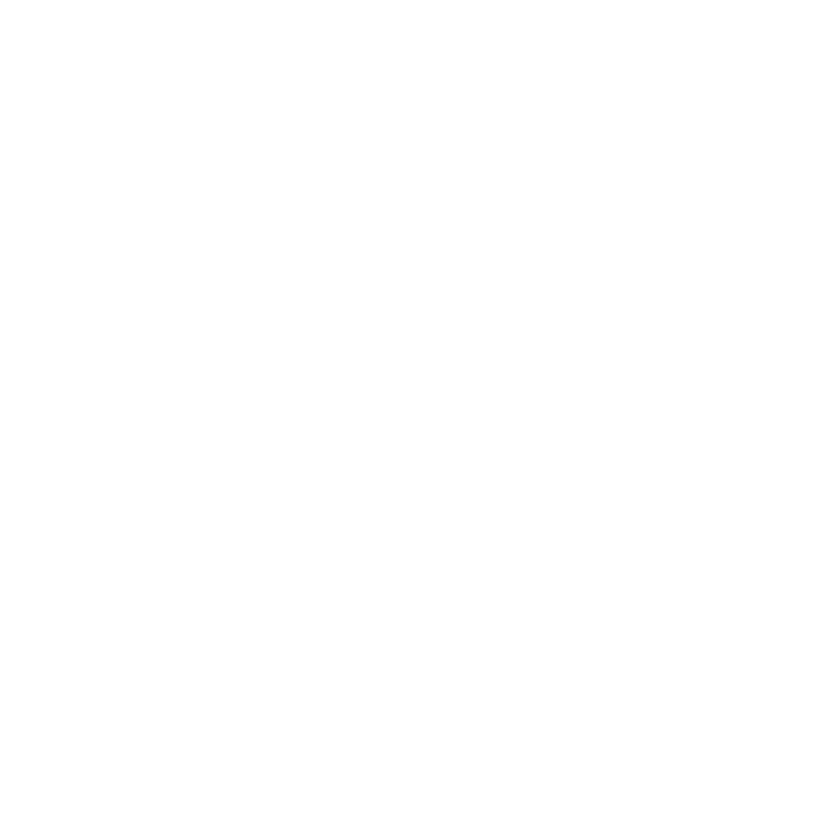

In [10]:
plot(x = subset(v_filteredData, algorithm=='MOACO')$destinations,
     y = subset(v_filteredData, algorithm=='MOACO')$hv60,
     cex  = 1,
     las  = 1,
     pch  = 16,
     col='red',
     xlab = "Destinations",
     ylab = "HV")

points(x = subset(v_filteredData, algorithm=='MOEA/D-ACO')$destinations,
     y = subset(v_filteredData, algorithm=='MOEA/D-ACO')$hv60,
     cex  = 1,
     pch  = 18,
     col='blue')

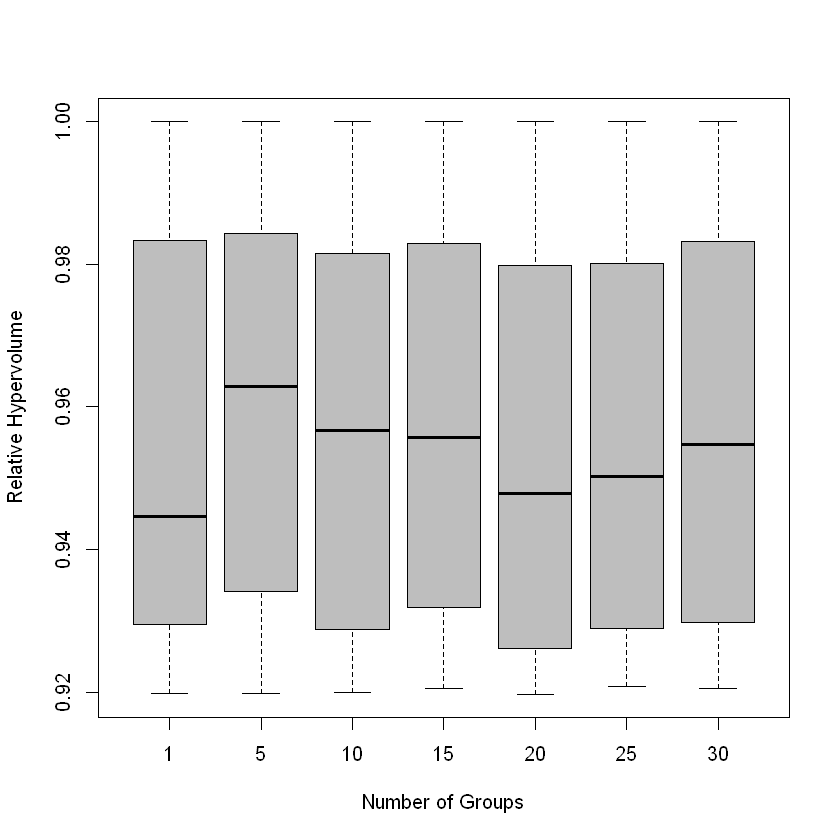

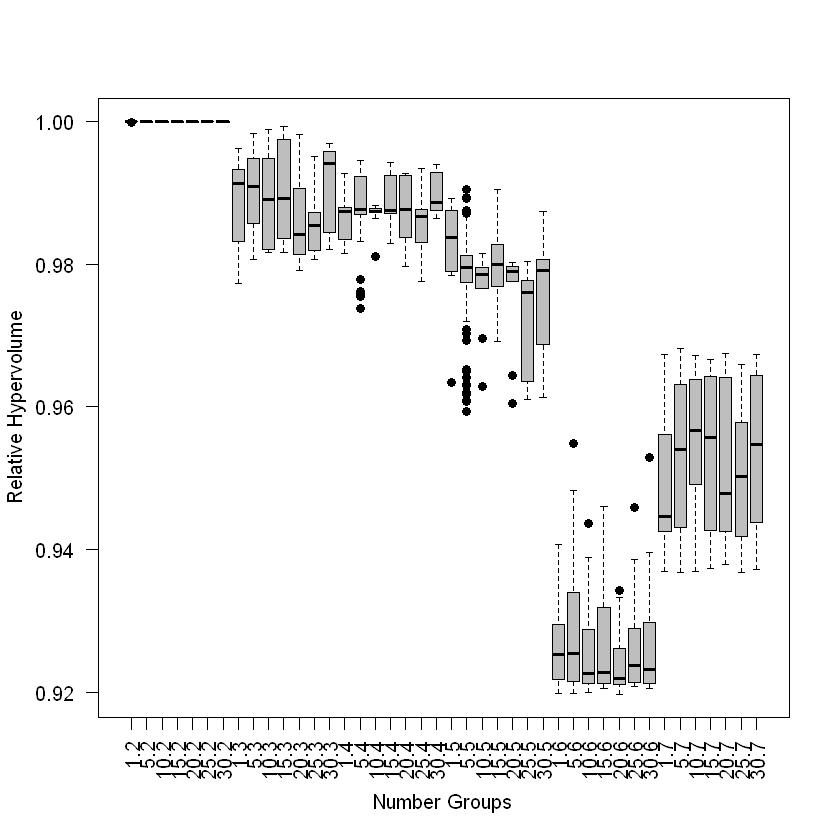

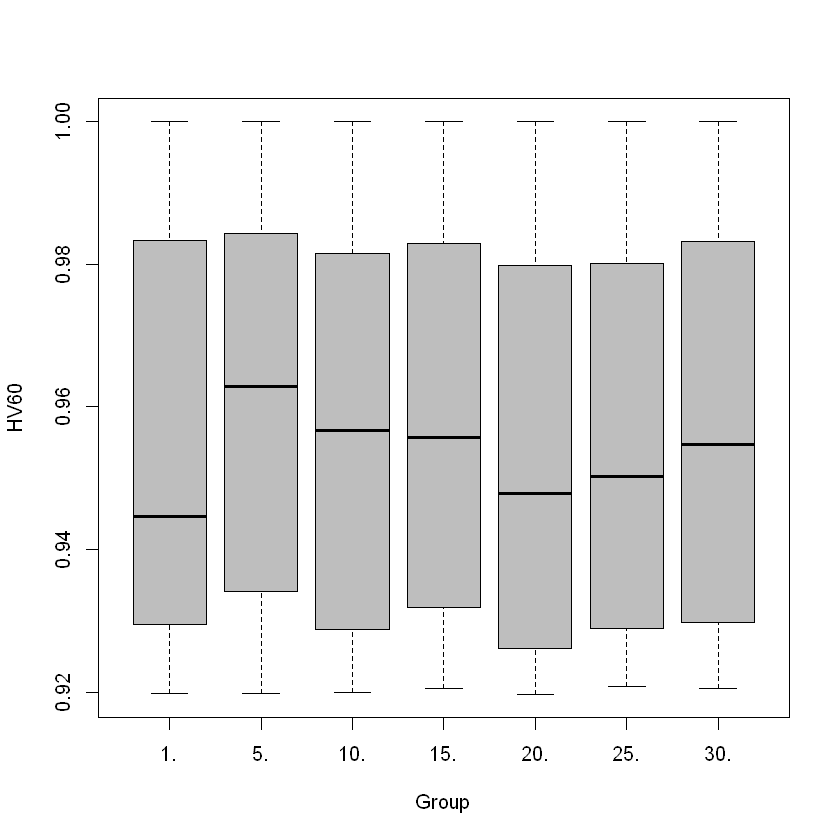

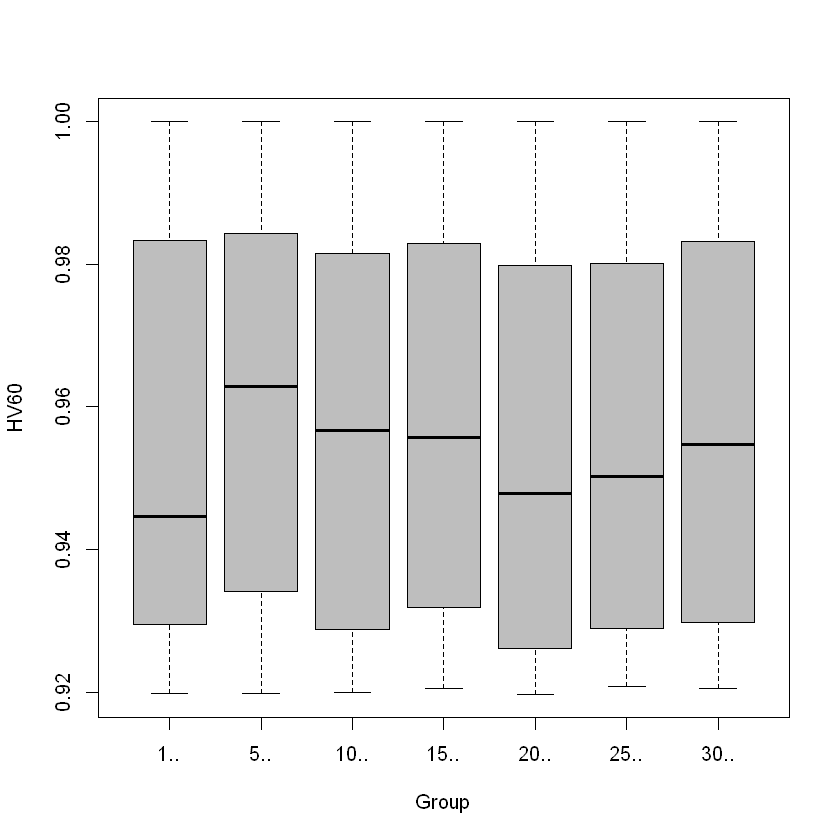

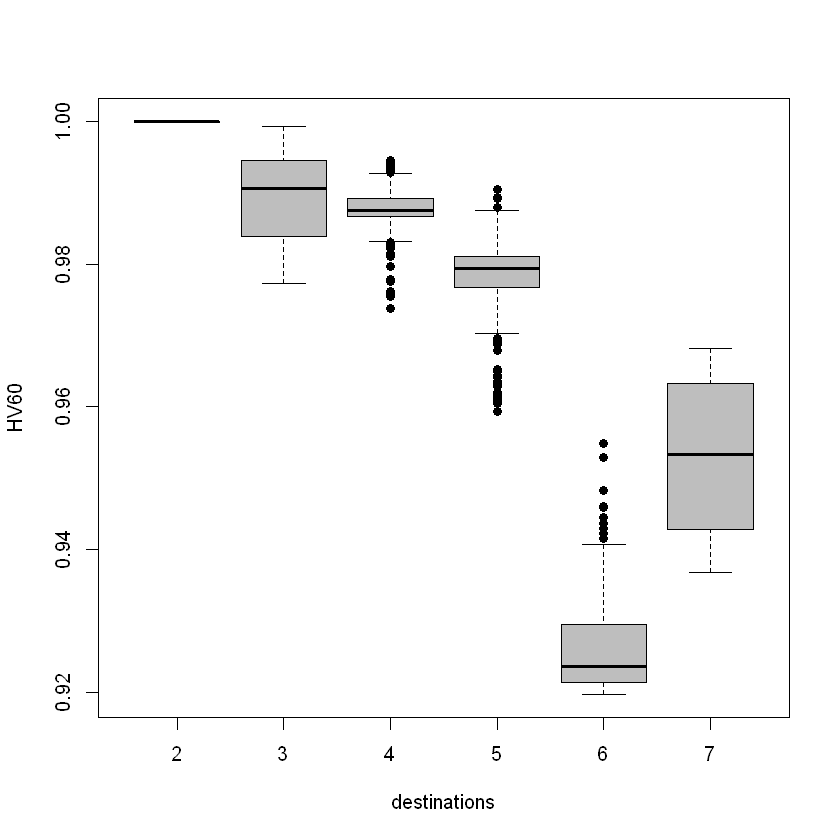

In [59]:
# hv

boxplot(hv60~groups,
        data = v_filteredData, 
        xlab = "Number of Groups",
        ylab = "Relative Hypervolume", 
        main = "",
        pch  = 16,
        col  = "gray")

boxplot(hv60~groups+destinations,
        data = v_filteredData, 
        xlab = "Number Groups",
        ylab = "Relative Hypervolume", 
        main = "",
        pch  = 16,
        las=2,
        col  = "gray")

boxplot(hv60~groups+localSearch,
        data = v_filteredData, 
        xlab = "Group",
        ylab = "HV60", 
        main = "",
        pch  = 16,
        col  = "gray")

boxplot(hv60~groups+localSearch+distributed,
        data = v_filteredData, 
        xlab = "Group",
        ylab = "HV60", 
        main = "",
        pch  = 16,
        col  = "gray")

boxplot(hv60~destinations,
        data = v_filteredData, 
        xlab = "destinations",
        ylab = "HV60", 
        main = "",
        pch  = 16,
        col  = "gray")


par(mar=c(20,5,4,1))


               Df Sum Sq Mean Sq F value Pr(>F)    
algorithm       1 0.7718  0.7718    1367 <2e-16 ***
destinations    1 3.0770  3.0770    5449 <2e-16 ***
Residuals    2587 1.4607  0.0006                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Call:
aov(formula = hv60 ~ algorithm + destinations, data = v_filteredData)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.096373 -0.017183 -0.000334  0.018067  0.054596 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          1.0306828  0.0015778  653.24   <2e-16 ***
algorithmMOEA/D-ACO  0.0406075  0.0009378   43.30   <2e-16 ***
destinations        -0.0221831  0.0003005  -73.82   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02376 on 2587 degrees of freedom
Multiple R-squared:  0.7249,	Adjusted R-squared:  0.7247 
F-statistic:  3408 on 2 and 2587 DF,  p-value: < 2.2e-16


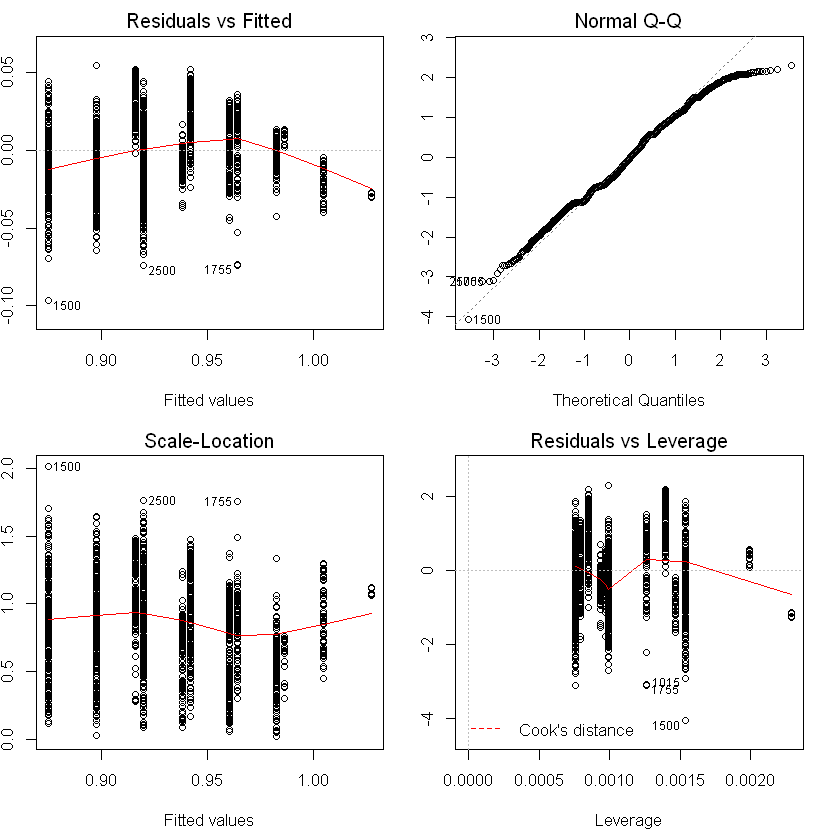

In [50]:
# v_anova <- aov(hv60~algorithm+as.factor(destinations), 
#                         data = v_filteredData)

v_anova <- aov(hv60~algorithm+destinations, 
                        data = v_filteredData)
summary.aov(v_anova)
summary.lm(v_anova)

par(mfrow=c(2,2), mai=.3*c(2.5,1,1,1))
plot(v_anova)

# v_tTestTime = t.test(hv60~algorithm,
#                     data=v_filteredData,
#                     mu = 0,
#                     conf.level = 0.95, 
#                     alternative = 'two.sided',
#                     paired=TRUE
# )
# v_tTestTime

# mudar de lugar
# Time - iteraction effects
# v_anova <- aov(hv60~algorithm*destinations, 
#                         data = v_filteredData)
# summary.aov(v_anova)
# summary.lm(v_anova)

# par(mfrow=c(2,2), mai=.3*c(2.5,1,1,1))
# plot(v_anova)

In [57]:
## ANOVA & MULTICOMP
v_alpha = 0.05
v_a = length(unique(v_filteredData$groups))
v_k = v_a*(v_a-1)/2
v_alphaAdj = v_alpha/v_k
v_beta = 0.2
v_power = 1-v_beta
v_delta = 0.01

v_powerAnova = pwr.anova.test(k = v_a, n = dim(v_filteredData)[1]/v_a, f = 0.1, sig.level = v_alpha)$power
print('PowerAnova:')
print(v_powerAnova)

# Welch Anova (accounting for heterocedascity)
oneway.test(hv60~algorithm+distributed+localSearch, data=v_filteredData, var.equal=FALSE)
# or
Anova(lm(hv60~algorithm+distributed+localSearch, data = v_filteredData), white.adjust = TRUE)


[1] "PowerAnova:"
[1] 0.699825


ERROR: Error in oneway.test(hv60 ~ algorithm + distributed + localSearch, data = v_filteredData, : not enough groups


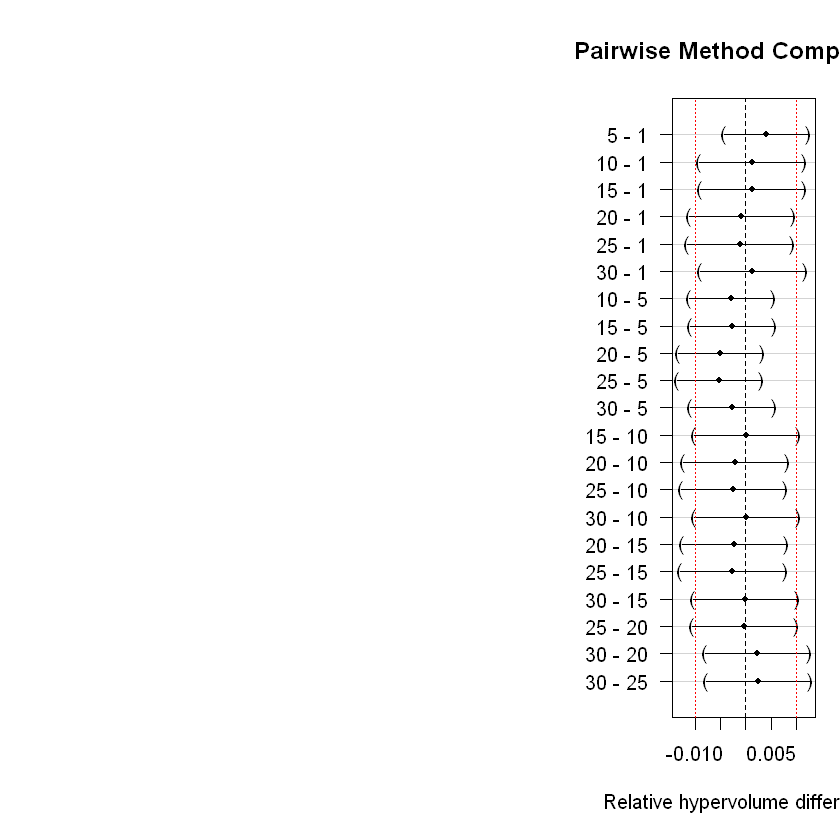

In [58]:
# Multiple comparison all-vs-all

v_dfMerged = v_filteredData
# v_dfMerged$method = paste( v_dfMerged$distributed, v_dfMerged$localSearch, v_dfMerged$algorithm,  sep = "")
# v_dfMerged$method = as.factor(v_dfMerged$method)

# v_dfMerged = v_dfMerged[v_dfMerged$destinations %in% c(6,7), ]
# v_dfMerged = v_dfMerged[v_dfMerged$algorithm == 'MOACO', ]

v_model <- lm(hv60~groups,
               data = v_dfMerged)
v_tukey = glht(v_model, linfct=mcp(groups = "Tukey"))
v_tukeyCI = confint(v_tukey, level=1-v_alpha)
par(mfrow=c(1,1), mar=c(5.1,28,4.1,1))
plot(v_tukeyCI, xlab = "Relative hypervolume difference", main='Pairwise Method Comparison')
abline(v=c(v_delta, -v_delta), col='red', lty=3)
par(mfrow=c(1,1), mar=c(5.1,4.1,4.1,2.1))

In [84]:
v_dataMergedFiltered = v_dfMerged[v_dfMerged$method %in% c('  MOACO', ' Loc MOACO'), ]

oneway.test(hv60~method+destinations, data=v_dataMergedFiltered, var.equal=TRUE)

Anova(lm(hv60~method+destinations, data = v_dataMergedFiltered), white.adjust = TRUE)


	One-way analysis of means

data:  hv60 and method + destinations
F = 561.13, num df = 11, denom df = 733, p-value < 2.2e-16


Df  F          Pr(>F)      
method         1   97.09128 1.309745e-21
destinations   1 4915.82251 0.000000e+00
Residuals    742         NA           NA